# 1. Import the libraries

In [2]:
# Third party libraries
import matplotlib.pyplot as plt
import torch

from torchvision import models, transforms
from torchattacks import FGSM
from sklearn.metrics import (
    classification_report,
    confusion_matrix)
    
# Local module
from helper import (
    image_processing,
    cnn_model,
    model_training,
    model_testing,
    adversarial_training)

## 1.2 Set the device & seed

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)

# 2. Preprocess the data

In [4]:
train_data, test_data = image_processing(
    train_path = "data/train",
    test_path = "data/test",
    batch_train = 100,
    batch_test = 10)

## 2.1 Lambda function for label changer

In [5]:
int_to_label = lambda label_in_tensor : [
    str(label).replace('0', 'cat').replace('1', 'dog')
    for label in label_in_tensor.tolist()]

## 2.2 Show some images

In [6]:
to_pil = transforms.ToPILImage()
train_data_img, train_data_label = iter(train_data).next()

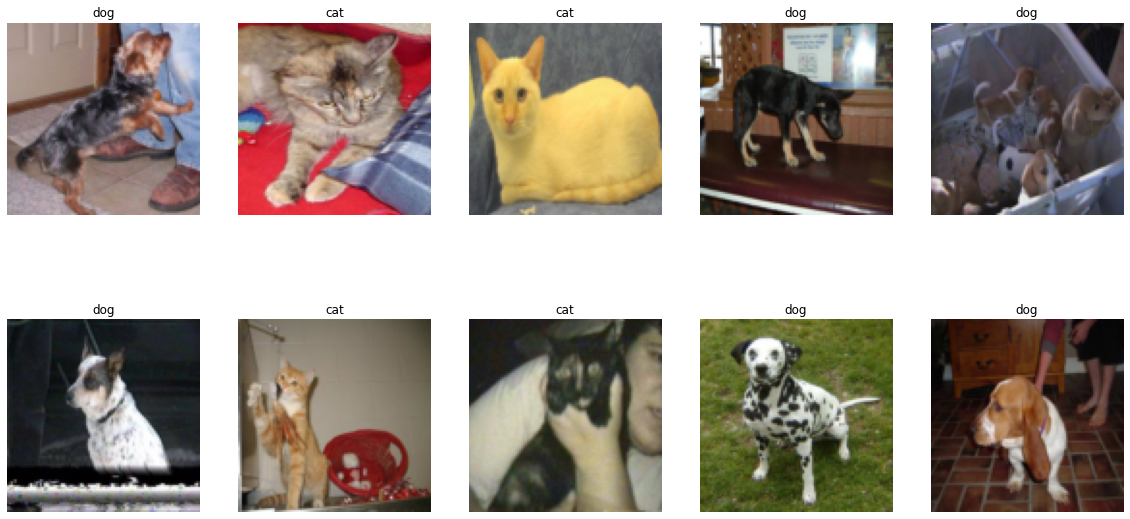

In [7]:
fig = plt.figure(figsize=(20,10))
rows,columns = 2,5
proper_label = int_to_label(train_data_label)

for i in range(10):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(to_pil(train_data_img[i].cpu()))
    plt.title(proper_label[i])
    plt.axis('off')

# 3. Load the model

In [21]:
shufflenetv2, loss_fn, optimizer = cnn_model(
    models.shufflenet_v2_x1_0(pretrained=True))

# 4. Train the model normally

In [9]:
shufflenetv2 = model_training(
    batch_size = 100,
    data_train = train_data,
    num_epochs = 25,
    model = shufflenetv2,
    loss_func = loss_fn,
    optimizer = optimizer)

Epoch: 1, Loss: 0.7566
Epoch: 2, Loss: 0.6287
Epoch: 3, Loss: 0.5041
Epoch: 4, Loss: 0.4718
Epoch: 5, Loss: 0.4168
Epoch: 6, Loss: 0.4050
Epoch: 7, Loss: 0.3759
Epoch: 8, Loss: 0.3474
Epoch: 9, Loss: 0.3069
Epoch: 10, Loss: 0.3049
Epoch: 11, Loss: 0.2925
Epoch: 12, Loss: 0.2564
Epoch: 13, Loss: 0.2356
Epoch: 14, Loss: 0.2455
Epoch: 15, Loss: 0.2075
Epoch: 16, Loss: 0.2793
Epoch: 17, Loss: 0.2680
Epoch: 18, Loss: 0.2640
Epoch: 19, Loss: 0.2998
Epoch: 20, Loss: 0.1781
Epoch: 21, Loss: 0.1677
Epoch: 22, Loss: 0.1763
Epoch: 23, Loss: 0.1819
Epoch: 24, Loss: 0.1971
Epoch: 25, Loss: 0.1819


# 5. Evaluate the model

In [10]:
conf_matrx, class_report = model_testing(test_data, shufflenetv2)

print(f'Confusion Matrix:\n{conf_matrx}\n')
print(f'Classification report:\n{class_report}')

Confusion Matrix:
[[110  19]
 [ 15 114]]

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       129
           1       0.86      0.88      0.87       129

    accuracy                           0.87       258
   macro avg       0.87      0.87      0.87       258
weighted avg       0.87      0.87      0.87       258



# 6. Check the trained model robustness

In [11]:
# Adv method initialization
atk = FGSM(shufflenetv2)
actual, atk_prediction = [], []

for images, labels in test_data:
    # Add noisy to the data
    images = atk(images, labels).cuda()
    test = images.view(-1, 3, 100, 100)
    # Attack the model
    outputs = shufflenetv2(test)

    _, predicted = torch.max(outputs.data, 1)
    
    actual.extend(labels.data.tolist())
    atk_prediction.extend(predicted.data.tolist())

print(
    "Confusion matrix:\n",
    confusion_matrix(actual, atk_prediction))
print(
    "\nClassification report:\n",
    classification_report(actual, atk_prediction))

Confusion matrix:
 [[ 12 117]
 [ 95  34]]

Classification report:
               precision    recall  f1-score   support

           0       0.11      0.09      0.10       129
           1       0.23      0.26      0.24       129

    accuracy                           0.18       258
   macro avg       0.17      0.18      0.17       258
weighted avg       0.17      0.18      0.17       258



# 7. Adversarial training

In [12]:
advtr_shufflenetv2, loss_fn, optimizer = cnn_model(
    models.shufflenet_v2_x1_0(pretrained=True))

In [13]:
robust_shufflenetv2 = adversarial_training(
    batch_size = 100,
    data_train = train_data,
    num_epochs = 25,
    model = advtr_shufflenetv2,
    loss_func = loss_fn,
    optimizer = optimizer,
    adv_method = FGSM)

Epoch: 1, Loss: 0.7981
Epoch: 2, Loss: 0.8168
Epoch: 3, Loss: 0.8047
Epoch: 4, Loss: 0.8262
Epoch: 5, Loss: 0.8082
Epoch: 6, Loss: 0.8060
Epoch: 7, Loss: 0.8048
Epoch: 8, Loss: 0.8034
Epoch: 9, Loss: 0.8015
Epoch: 10, Loss: 0.8031
Epoch: 11, Loss: 0.7995
Epoch: 12, Loss: 0.8013
Epoch: 13, Loss: 0.8009
Epoch: 14, Loss: 0.7979
Epoch: 15, Loss: 0.8000
Epoch: 16, Loss: 0.7984
Epoch: 17, Loss: 0.7922
Epoch: 18, Loss: 0.7948
Epoch: 19, Loss: 0.7974
Epoch: 20, Loss: 0.7896
Epoch: 21, Loss: 0.7870
Epoch: 22, Loss: 0.7861
Epoch: 23, Loss: 0.7767
Epoch: 24, Loss: 0.7798
Epoch: 25, Loss: 0.7694


## 7.1 Evaluate it with the normal data

In [14]:
robust_model_conf_matrx, robust_model_class_report = model_testing(
    test_data, robust_shufflenetv2)

print(f'Confusion Matrix:\n{robust_model_conf_matrx}\n')
print(f'Classification report:\n{robust_model_class_report}')

Confusion Matrix:
[[107  22]
 [ 11 118]]

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       129
           1       0.84      0.91      0.88       129

    accuracy                           0.87       258
   macro avg       0.87      0.87      0.87       258
weighted avg       0.87      0.87      0.87       258



## 7.2 Evaluate it with the perturbed data

In [15]:
# Adv method initialization
atk = FGSM(robust_shufflenetv2, eps=0.03)
actual, predict = [], []

for images, labels in test_data:
    # Add noisy to the data
    images = atk(images, labels).cuda()
    test = images.view(-1, 3, 100, 100)
    # Attack the model
    outputs = robust_shufflenetv2(test)

    _, predicted = torch.max(outputs.data, 1)
    
    actual.extend(labels.data.tolist())
    predict.extend(predicted.data.tolist())

print(
    "\nConfusion matrix\n",
    confusion_matrix(actual, predict))
print(
    "\nClassification report\n",
    classification_report(actual, predict))


Confusion matrix
 [[ 13 116]
 [ 31  98]]

Classification report
               precision    recall  f1-score   support

           0       0.30      0.10      0.15       129
           1       0.46      0.76      0.57       129

    accuracy                           0.43       258
   macro avg       0.38      0.43      0.36       258
weighted avg       0.38      0.43      0.36       258



# 8. Image showcase

In [16]:
test_images, test_labels = iter(test_data).next()

## 8.1 Standard model on perturbed data

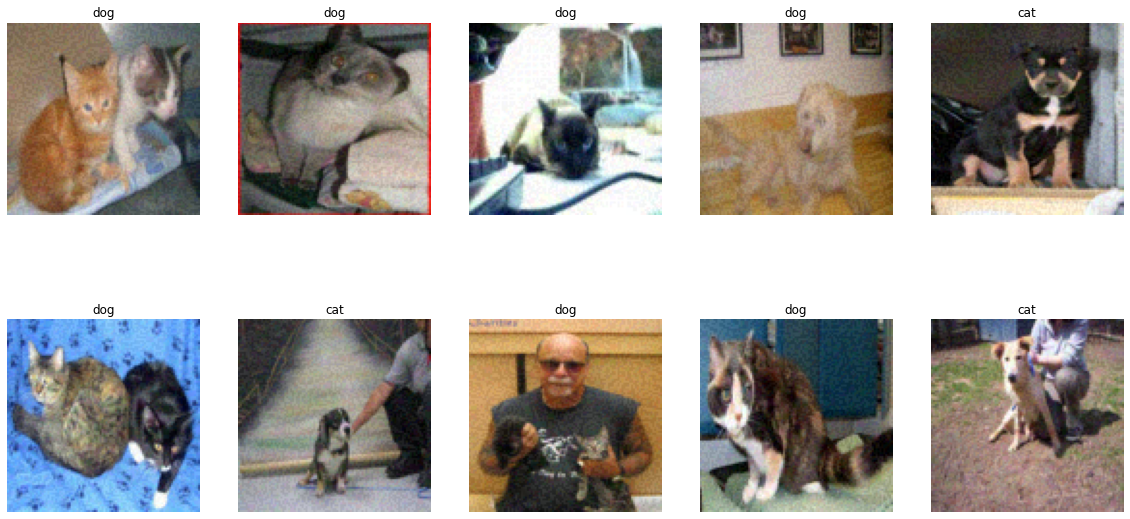

In [17]:
# Adv method initialization
atk = FGSM(shufflenetv2, eps=0.03)
# Add noisy to images
atk_images = atk(test_images, test_labels).cuda()
ptb_img = atk_images.view(-1, 3, 100, 100)
# Attack the model
outputs = shufflenetv2(ptb_img)

_, atk_predicted_label = torch.max(outputs.data, 1)

fig = plt.figure(figsize=(20,10))
proper_label = int_to_label(atk_predicted_label)

# Show the images
for i in range(10):
    fig.add_subplot(rows, columns, i+1)
    
    plt.imshow(to_pil(atk_images[i].cpu()))
    plt.title(proper_label[i])
    plt.axis('off')

# 8.2 (robust) model on normal data

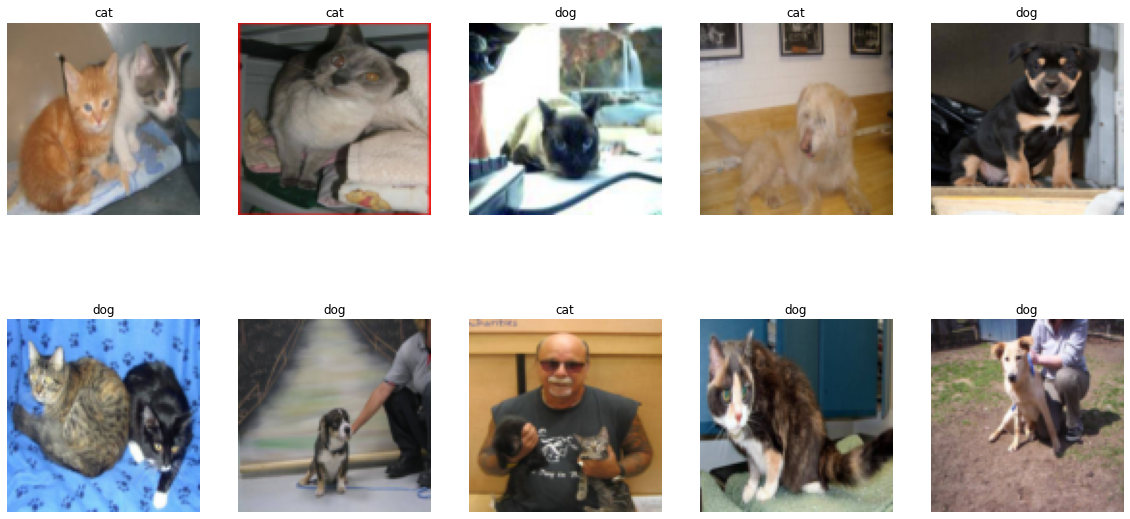

In [18]:
images = test_images.to(device)
normal_img = images.view(-1, 3, 100, 100)
outputs = robust_shufflenetv2(normal_img)

_, norm_predicted_label = torch.max(outputs.data, 1)

fig = plt.figure(figsize=(20,10))
proper_label = int_to_label(norm_predicted_label)

# Show the images
for i in range(10):
    fig.add_subplot(rows, columns, i+1)
    
    plt.imshow(to_pil(test_images[i].cpu()))
    plt.title(proper_label[i])
    plt.axis('off')

## 8.3 (robust) model on perturbed data

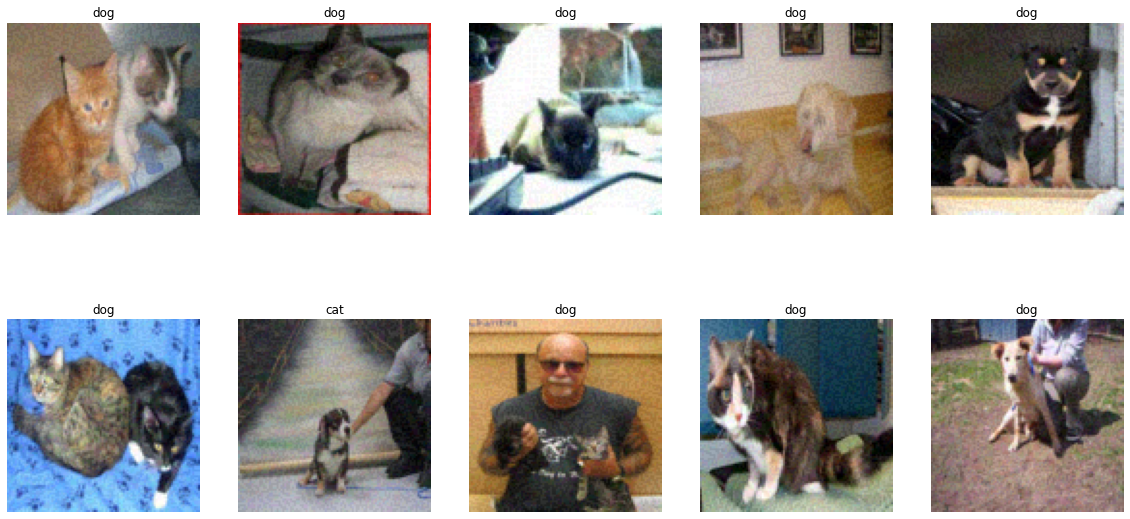

In [19]:
# Adv method initialization
atk = FGSM(robust_shufflenetv2, eps=0.03)
# Add noisy to images
atk_images = atk(test_images, test_labels).cuda()
ptb_img = atk_images.view(-1, 3, 100, 100)
# Attack the model
outputs = robust_shufflenetv2(ptb_img)

_, atk_predicted_label = torch.max(outputs.data, 1)

fig = plt.figure(figsize=(20,10))
proper_label = int_to_label(atk_predicted_label)

# Show the images
for i in range(10):
    fig.add_subplot(rows, columns, i+1)
    
    plt.imshow(to_pil(atk_images[i].cpu()))
    plt.title(proper_label[i])
    plt.axis('off')

## 8.4 What is the difference?

(-0.5, 99.5, 99.5, -0.5)

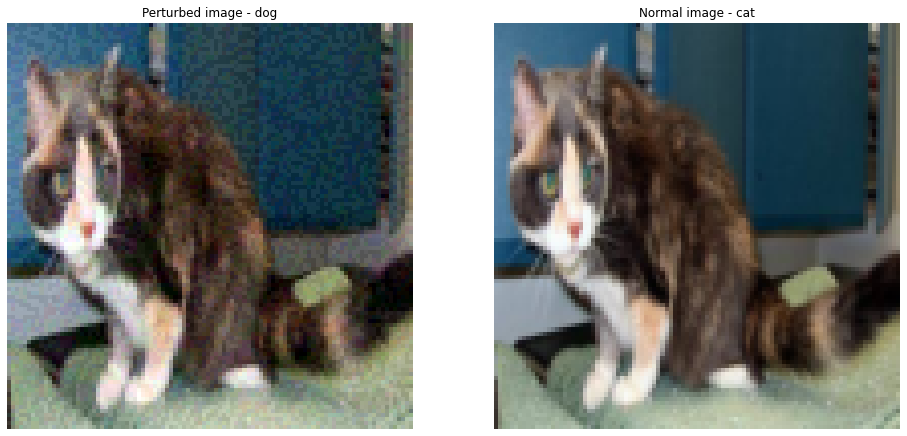

In [20]:
fig = plt.figure(figsize=(16,8))
true_label = int_to_label(test_labels)
atk_label = int_to_label(atk_predicted_label)

# PERTURBED IMAGE
fig.add_subplot(1, 2, 1)
plt.imshow(to_pil(atk_images[8].cpu()))
plt.title(f"Perturbed image - {atk_label[8]}")
plt.axis('off')

# NORMAL IMAGE
fig.add_subplot(1, 2, 2)
plt.imshow(to_pil(test_images[8].cpu()))
plt.title(f"Normal image - {true_label[8]}")
plt.axis('off')